In [2]:
import pandas as pd
import re
import numpy as np

In [4]:
dt1 = pd.read_csv("firstname_with_sex.csv", sep = ';')
dt2 = pd.read_csv("transcriptions_with_sex.csv")
transcriptions = pd.read_csv('transcriptions_with_sex.csv', names=['id', 'manual', 'auto', 'sexe'])

Analyse des données

In [ ]:
len(dt2), len(dt1)

(241, 6946)

In [ ]:
dt2.columns, dt1.columns

(Index(['subject_line', 'groundtruth', 'prediction', 'sex'], dtype='object'),
 Index(['firstname', 'male', 'female'], dtype='object'))

In [ ]:
dt2.head()

,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme


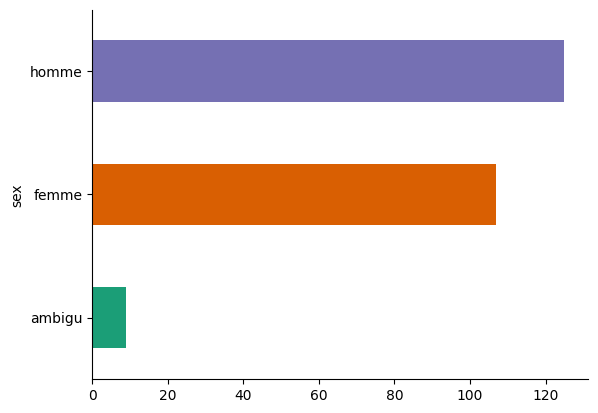

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
dt2.groupby('sex').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
dt1.head()

,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951


Méthode naïve basée sur le prénom

In [5]:
def extract_first_name(text):
    match = re.search(r'firstname:\s*(\w+)', text)
    return match.group(1) if match else None

transcriptions['prenom'] = transcriptions['manual'].apply(extract_first_name)


In [ ]:
dt2['sex'].unique()

array(['femme', 'homme', 'ambigu'], dtype=object)

In [6]:
def predict(prenom):
    prenom = str(prenom.lower())
    ligne = dt1[dt1['firstname'] == prenom]
    if ligne.empty:
        rd = np.random.random()
        if rd < 0.5:
            return 'homme'
        else:
            return 'femme'
    if ligne['male'].item() > ligne['female'].item():
        return 'homme'
    else:
        return 'femme'

In [7]:
n = len(transcriptions)
acc = 0
for i in range(n):
    prenom = transcriptions['prenom'][i]
    if prenom == None:
        rd = np.random.random()
        if rd < 0.5:
            pred = 'homme'
        else:
            pred = 'femme'
    else:
        pred = predict(prenom)
    if pred == transcriptions['sexe'][i]:
        acc += 1
print(acc/(n-9))

0.9828326180257511


In [8]:
l = []
n = len(dt2)
for _ in range(40):
  acc = 0
  for i in range(n):
    prenom = transcriptions['prenom'][i+1]
    if prenom == None:
      rd = np.random.random()
      if rd < 0.5:
        pred = 'homme'
      else:
        pred = 'femme'
    else:
      pred = predict(prenom)
    if pred == dt2['sex'][i]:
      acc += 1
  l.append(acc/n)
print(f"L'accuracy de la méthode naïve vaut {np.mean(l)}")

L'accuracy de la méthode naïve vaut 0.9517634854771785


Modèles de Machine Learning

In [ ]:
dt_ml = dt2.copy()

from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("SVM", SVC(probability=True)),
    ("KNN", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier())
]


vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(dt_ml['prediction'])


loo = LeaveOneOut()


for name, model in models:
    pipeline = Pipeline([
        ('scaler', StandardScaler(with_mean=False)), # SVM, Logistic Regression bénéficient de la mise à l'échelle
        ('classifier', model)
    ])

    scores = cross_val_score(pipeline, X_vectorized, dt_ml['sex'], cv=loo, scoring='accuracy')
    accuracy = np.mean(scores)

    print(f"{name} Accuracy: {accuracy:.4f}")


Logistic Regression Accuracy: 0.8008
SVM Accuracy: 0.6639
KNN Accuracy: 0.5187
Decision Tree Accuracy: 0.7842
Random Forest Accuracy: 0.7759
Gradient Boosting Accuracy: 0.8174


Modèles de Deep Learning

In [ ]:
#modèles pré-entraînés
from transformers import pipeline
from sklearn.metrics import accuracy_score, classification_report

dt_dl = dt2.copy()

# Liste des modèles BERT à tester
models_to_test = [
    "bert-base-multilingual-cased",
    "camembert/camembert-base",
    "flaubert/flaubert_large_cased",
    "facebook/bart-large",
    "camembert/camembert-large"
]

# Labels pour la classification
labels = ["masculin", "feminin"]

# Mapping des labels prédits vers les labels originaux
label_mapping = {
    'masculin': 'homme',
    'feminin': 'femme'
}

# Itérer sur chaque modèle
for model_name in models_to_test:
    print(f"Évaluation du modèle: {model_name}")

    # Initialiser le pipeline de classification zero-shot
    classifier = pipeline("zero-shot-classification", model=model_name)

    # Classifier les textes
    predicted_sexes = []
    for text in dt_dl['prediction']:
        result = classifier(text, candidate_labels=labels, hypothesis_template="Cette personne est de sexe {}.")
        predicted_label = result['labels'][0]
        predicted_sexes.append(predicted_label)

    # Ajouter les résultats au DataFrame
    dt_dl['predicted_sex'] = predicted_sexes

    # Filtrer pour exclure les entrées 'ambigu'
    transcription_sex_filtered = dt_dl[dt_dl['sex'] != 'ambigu']

    # Appliquer le mapping des labels prédits
    transcription_sex_filtered['predicted_sex_mapped'] = transcription_sex_filtered['predicted_sex'].map(label_mapping)

    # Calculer la précision
    accuracy = accuracy_score(transcription_sex_filtered['sex'], transcription_sex_filtered['predicted_sex_mapped'])

    # Afficher les résultats
    print(f"Précision du modèle: {accuracy:.4f}")
    print(classification_report(transcription_sex_filtered['sex'], transcription_sex_filtered['predicted_sex_mapped'], target_names=list(label_mapping.values())))

    # Pour la lisibilité des résultats
    print("\n" + "="*50 + "\n")


Évaluation du modèle: bert-base-multilingual-cased


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
<ipython-input-37-750747c00588>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcription_sex_filtered['predicted_sex_mapped'] = transcription_sex_filtered['predicted_sex'].map(label_mapping)


Précision du modèle: 0.2931
              precision    recall  f1-score   support

       homme       0.32      0.46      0.37       107
       femme       0.25      0.15      0.19       125

    accuracy                           0.29       232
   macro avg       0.28      0.30      0.28       232
weighted avg       0.28      0.29      0.27       232



Évaluation du modèle: camembert/camembert-base


config.json:   0%|          | 0.00/509 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert/camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
<ipython-input-37-750747c00588>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcription_sex_filtered['predicted_sex_mapped'] = transcription_sex_filtered['predicted_sex'].map(label_mapping)


Précision du modèle: 0.5302
              precision    recall  f1-score   support

       homme       0.44      0.07      0.13       107
       femme       0.54      0.92      0.68       125

    accuracy                           0.53       232
   macro avg       0.49      0.50      0.40       232
weighted avg       0.49      0.53      0.42       232



Évaluation du modèle: flaubert/flaubert_large_cased


Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_large_cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
<ipython-input-37-750747c00588>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcription_sex_filtered['predicted_sex_mapped'] = transcription_sex_filtered['predicted_sex'].map(label_mapping)


Précision du modèle: 0.5560
              precision    recall  f1-score   support

       homme       0.51      0.65      0.58       107
       femme       0.61      0.47      0.53       125

    accuracy                           0.56       232
   macro avg       0.56      0.56      0.56       232
weighted avg       0.57      0.56      0.55       232



Évaluation du modèle: facebook/bart-large


config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
<ipython-input-37-750747c00588>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcription_sex_filtered['predicted_sex_mapped'] = transcription_sex_filtered['predicted_sex'].map(label_mapping)


Précision du modèle: 0.6078
              precision    recall  f1-score   support

       homme       0.61      0.42      0.50       107
       femme       0.61      0.77      0.68       125

    accuracy                           0.61       232
   macro avg       0.61      0.59      0.59       232
weighted avg       0.61      0.61      0.59       232



Évaluation du modèle: camembert/camembert-large


config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert/camembert-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'roberta.embeddings.word_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


sentencepiece.bpe.model:   0%|          | 0.00/809k [00:00<?, ?B/s]

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Précision du modèle: 0.4828
              precision    recall  f1-score   support

       homme       0.39      0.21      0.28       107
       femme       0.51      0.71      0.60       125

    accuracy                           0.48       232
   macro avg       0.45      0.46      0.44       232
weighted avg       0.46      0.48      0.45       232





<ipython-input-37-750747c00588>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcription_sex_filtered['predicted_sex_mapped'] = transcription_sex_filtered['predicted_sex'].map(label_mapping)


Combinaisons

In [ ]:
new_dt2 = dt2.copy()
n = len(new_dt2)
new_dt2['proba_male'] = np.nan
new_dt2['proba_female'] = np.nan #probablement inutile

for i in range(n):
    prenom = transcriptions['prenom'][i]
    if prenom == None:
      new_dt2['proba_male'][i] = 0.5
      new_dt2['proba_female'][i] = 0.5
    else:
      prenom = str(prenom.lower())
      ligne = dt1[dt1['firstname'] == prenom]
      if ligne.empty:
        new_dt2['proba_male'][i] = 0.5
        new_dt2['proba_female'][i] = 0.5
      else:
        n1 = ligne['male'].item()
        n2 = ligne['female'].item()
        new_dt2['proba_male'][i] = n1/(n1 + n2)
        new_dt2['proba_female'][i] = n2/(n1 + n2)


In [ ]:
new_dt2.head()

,subject_line,groundtruth,prediction,sex,proba_male,proba_female
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme,0.500000,0.500000
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme,0.004226,0.995774
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme,0.996389,0.003611
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme,0.004226,0.995774
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme,0.004226,0.995774


In [ ]:
new_dt_ml = new_dt2.copy()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
# Initialisation des modèles à tester
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("SVM", SVC(probability=True)),
    ("KNN", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier())
]


preprocessor = ColumnTransformer(
    transformers=[
        ('txt', CountVectorizer(), 'prediction'),
        ('num', 'passthrough', ['proba_male', 'proba_female'])
    ])

#vectorizer = TfidfVectorizer()
#vectorizer = CountVectorizer()
#X_vectorized = vectorizer.fit_transform(new_dt_ml['prediction'])
#X = new_dt_ml.drop(['sex', 'prediction'], axis=1)

loo = LeaveOneOut()


for name, model in models:
    pipeline = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', model)
      ])

    X = new_dt_ml.drop('sex', axis=1)
    y = new_dt_ml['sex']

    scores = cross_val_score(pipeline, X, y, cv=loo, scoring='accuracy')
    accuracy = np.mean(scores)

    print(f"{name} Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 0.8091
SVM Accuracy: 0.7635
KNN Accuracy: 0.6307
Decision Tree Accuracy: 0.7552
Random Forest Accuracy: 0.7759
Gradient Boosting Accuracy: 0.8008


In [10]:
dt_link = dt2.copy()
dt_link['link'] = dt_link['groundtruth'].str.extract(r'link:\s*([\w-]+)')
dt_link['occupation'] = dt_link['groundtruth'].str.extract(r'occupation:\s*([^:]+?)(?:\s+[a-z]+:|$)')

In [ ]:
dt_link['link'].unique()

array(['fille', 'chef', 'idem', 'femme', nan, 'fils', 'enfant', 'Sa',
       'enf', 'Chef', 'épouse', 'domestique', 'ép', 'père', 'mère',
       'Domestique', 'belle-mère', 'Fils', 'petite-fille', 'sa', 'Leur',
       'petit-fils', 'bru', 'pensionnaire', 'leur', 'mére', 'assisté',
       'ouvrier', 'frère', 'Schouer', 'Son', 'ch', 'son', 'domest'],
      dtype=object)

In [11]:
link_male = ['chef', 'fils', 'Chef', 'père', 'Fils', 'petit-fils', 'assisté', 'ouvrier', 'frère', 'Son', 'son']
link_female = ['fille', 'femme', 'épouse', 'mère', 'belle-mère', 'petite-fille', 'bru', 'mére']

In [ ]:
new2_dt2 = new_dt2.copy()
n = len(new2_dt2)
new2_dt2['link_male'] = np.nan
new2_dt2['link_female'] = np.nan

for i in range(n):
    link = dt_link['link'][i]
    if link in link_male:
      new2_dt2['link_male'][i] = 1
      new2_dt2['link_female'][i] = 0
    elif link in link_female:
      new2_dt2['link_male'][i] = 0
      new2_dt2['link_female'][i] = 1
    else:
      new2_dt2['link_male'][i] = 0.5
      new2_dt2['link_female'][i] = 0.5

In [ ]:
new2_dt2.head()

,subject_line,groundtruth,prediction,sex,proba_male,proba_female,link_male,link_female
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme,0.500000,0.500000,0.0,1.0
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme,0.004226,0.995774,1.0,0.0
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme,0.996389,0.003611,0.5,0.5
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme,0.004226,0.995774,0.0,1.0
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme,0.004226,0.995774,0.5,0.5


In [ ]:
new_dt_ml = new2_dt2.copy()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("SVM", SVC(probability=True)),
    ("KNN", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier())
]

preprocessor = ColumnTransformer(
    transformers=[
        ('txt', CountVectorizer(), 'prediction'),
        ('num', 'passthrough', ['proba_male', 'proba_female', 'link_male', 'link_female'])
    ])

#vectorizer = TfidfVectorizer()
#vectorizer = CountVectorizer()
#X_vectorized = vectorizer.fit_transform(new_dt_ml['prediction'])
#X = new_dt_ml.drop(['sex', 'prediction'], axis=1)
# Initialisation de la validation croisée Leave-One-Out
loo = LeaveOneOut()


for name, model in models:
    pipeline = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', model)
      ])

    X = new_dt_ml.drop('sex', axis=1)
    y = new_dt_ml['sex']

    scores = cross_val_score(pipeline, X, y, cv=loo, scoring='accuracy')
    accuracy = np.mean(scores)

    print(f"{name} Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 0.8631
SVM Accuracy: 0.8423
KNN Accuracy: 0.7178
Decision Tree Accuracy: 0.8091
Random Forest Accuracy: 0.8382
Gradient Boosting Accuracy: 0.8340


In [ ]:
dt_link['occupation'].unique()

array(['idem', 'sp', nan, 'Métayer patron', 'néant', 'journalier',
       'cantonnier', 'Cultivateur', 'sans prof', 'domestique', 'couvreur',
       'roulier', 's.p', 'cultivateur', 'garde part.', 'journalière',
       'manoeuvre', 'forgeron', 'ouvrier', 'propriétaire', 'Domestique',
       'sans profession', 'voiturier', 's.p.', 'jardinier',
       'domestique de ferme', 'cult eur fermier', 'métayer',
       'cultivateur fermier', 'femme de chambre', 'sans prof.',
       'garde-champêtre', 'culivateur', 'cult eur', 'boulanger',
       'buraliste', 'sans p.', 'clerc de nptaire', 'quincaillier',
       'charcutier', 'sellier', 'Sans p', 'sans p', 'imprimeur',
       'cullotière', 'employé', 'blanchiseuse', 's p', 'nourrisson',
       'journalier terrassier', 'cultivatrice', 'cultivat', 'charretier',
       'rentière', 'repasseuse', 'receveur enregistrement',
       'Garde particulier', 'ouvrier meunier', 'domest.', 'menuisier',
       'tourneur', 'agent de police', 'couturière', 'déposi

In [13]:
suffixe_female = ["ière", "euse", "ice"]
suffixe_male = ["eur", "ier", "er"]

In [14]:
def extract_suffix(word, n=2):
  if pd.notna(word):
    return word[-n:]
  else:
    return("nan")

suffixes = [extract_suffix(word, 1) for word in dt_link['occupation'] if pd.notna(word)]

In [ ]:
new3_dt2 = new2_dt2.copy()
n = len(new3_dt2)
new3_dt2['occ_male'] = np.nan
new3_dt2['occ_female'] = np.nan

for i in range(n):
    a = 0
    word = dt_link['occupation'][i]
    for suf in suffixe_male:
      if extract_suffix(word, len(suf)) == suf:
        new3_dt2['occ_male'][i] = 1
        new3_dt2['occ_female'][i] = 0
        a = 1
    for suf in suffixe_female:
      if extract_suffix(word, len(suf)) == suf:
        new3_dt2['occ_male'][i] = 0
        new3_dt2['occ_female'][i] = 1
        a = 1
    if a == 0:
      new3_dt2['occ_male'][i] = 0.5
      new3_dt2['occ_female'][i] = 0.5

In [ ]:
new3_dt2.columns

Index(['subject_line', 'groundtruth', 'prediction', 'sex', 'proba_male',
       'proba_female', 'link_male', 'link_female', 'occ_male', 'occ_female'],
      dtype='object')

In [ ]:
new_dt_ml = new3_dt2.copy()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("SVM", SVC(probability=True)),
    ("KNN", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier())
]

preprocessor = ColumnTransformer(
    transformers=[
        ('txt', CountVectorizer(), 'prediction'),
        ('num', 'passthrough', ['proba_male', 'proba_female', 'link_male', 'link_female', 'occ_male', 'occ_female'])
    ])

#vectorizer = TfidfVectorizer()
#vectorizer = CountVectorizer()
#X_vectorized = vectorizer.fit_transform(new_dt_ml['prediction'])
#X = new_dt_ml.drop(['sex', 'prediction'], axis=1)
# Initialisation de la validation croisée Leave-One-Out
loo = LeaveOneOut()

for name, model in models:
    pipeline = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', model)
      ])

    X = new_dt_ml.drop('sex', axis=1)  # Supposer que 'sex' est la colonne cible
    y = new_dt_ml['sex']

    scores = cross_val_score(pipeline, X, y, cv=loo, scoring='accuracy')
    accuracy = np.mean(scores)

    print(f"{name} Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 0.8548
SVM Accuracy: 0.8423
KNN Accuracy: 0.7261
Decision Tree Accuracy: 0.8216
Random Forest Accuracy: 0.8340
Gradient Boosting Accuracy: 0.8382


In [ ]:
#tentative d'entrainement de BERT

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split

data = new3_dt2[new3_dt2['sex'] != 'ambigu']
data = data.dropna(subset=['prediction', 'sex'])

label_map = {'homme': 0, 'femme': 1}
data['label'] = data['sex'].map(label_map)

df_train, df_val = train_test_split(data, test_size=0.1, random_state=42)

class SexClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=2)

MAX_LEN = 128
BATCH_SIZE = 16

train_dataset = SexClassificationDataset(df_train['prediction'].to_numpy(), df_train['label'].to_numpy(), tokenizer, MAX_LEN)
val_dataset = SexClassificationDataset(df_val['prediction'].to_numpy(), df_val['label'].to_numpy(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * 3  # Pour 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

EPOCHS = 3
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(model, train_loader, torch.nn.CrossEntropyLoss(), optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss}, accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_loader, torch.nn.CrossEntropyLoss(), device, len(df_val))
    print(f'Validation loss {val_loss}, accuracy {val_acc}')
    print('-' * 10)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Train loss 0.703697667672084, accuracy 0.4855769230769231
Validation loss 0.4329926669597626, accuracy 0.9166666666666666
----------
Epoch 2/3
Train loss 0.3995288736545123, accuracy 0.8894230769230769
Validation loss 0.07126472890377045, accuracy 1.0
----------
Epoch 3/3
Train loss 0.20735976959650332, accuracy 0.9375
Validation loss 0.07910707965493202, accuracy 1.0
----------


In [16]:
#tout le code réaparrait car Colab a crashé entretemps

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split

data = new2_dt2[new2_dt2['sex'] != 'ambigu']
data = data.dropna(subset=['prediction', 'sex'])

label_map = {'homme': 0, 'femme': 1}
data['label'] = data['sex'].map(label_map)

df_train, df_val = train_test_split(data, test_size=0.1, random_state=42)

class SexClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=2)

MAX_LEN = 128
BATCH_SIZE = 16

train_dataset = SexClassificationDataset(df_train['prediction'].to_numpy(), df_train['label'].to_numpy(), tokenizer, MAX_LEN)
val_dataset = SexClassificationDataset(df_val['prediction'].to_numpy(), df_val['label'].to_numpy(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * 3  # Pour 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

EPOCHS = 3
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(model, train_loader, torch.nn.CrossEntropyLoss(), optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss}, accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_loader, torch.nn.CrossEntropyLoss(), device, len(df_val))
    print(f'Validation loss {val_loss}, accuracy {val_acc}')
    print('-' * 10)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Train loss 0.6838924884796143, accuracy 0.6009615384615384
Validation loss 0.5812646746635437, accuracy 0.625
----------
Epoch 2/3
Train loss 0.44739080850894636, accuracy 0.8125
Validation loss 0.1358468346297741, accuracy 0.9583333333333334
----------
Epoch 3/3
Train loss 0.3026932945045141, accuracy 0.9038461538461539
Validation loss 0.10865911655128002, accuracy 0.9583333333333334
----------
